In [1]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 79.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.1
    Uninstalling transformers-4.41.1:
      Successfully uninstalled transformers-4.41.1


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils, models
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import trange
from tqdm.auto import tqdm
import pandas as pd

from IPython.display import clear_output

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import gc

In [2]:
import nltk
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

import string

import spacy

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

model_cedr_name = "cointegrated/rubert-tiny2-cedr-emotion-detection"
model_evil_name = "apanc/russian-inappropriate-messages"

2024-06-17 10:11:12.104458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 10:11:12.104569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 10:11:12.226056: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pd.set_option('display.max_colwidth', 1000) 
RANDOM_STATE = 17
df_link = "/kaggle/input/avito-support/sentiment_dif.csv"
tqdm.pandas()

In [5]:
df = pd.read_csv(df_link)
df.head(5)

,dialog_ext,chat_id,msg_text,tokened,lem_tokened,sentiment_deeppavlov,emotions_rubert,probs_rubert
0,21680407,377088750303,"Здравствуйте, я забыл забрать посылку которую вернули. Есть возможность её вернуть?","['здравствуйте', 'я', 'забыл', 'забрать', 'посылку', 'которую', 'вернули', 'есть', 'возможность', 'её', 'вернуть']","['здравствовать', 'я', 'забыть', 'забрать', 'посылка', 'которую', 'вернуть', 'быть', 'возможность', 'её', 'вернуть']",neutral,sadness,[0.04774914 0.02008985 0.69820666 0.21859045 0.00900974 0.00635417]
1,24599757,462608250741,Здравствуйте где сейчас мой заказ едет,"['здравствуйте', 'где', 'сейчас', 'мой', 'заказ', 'едет']","['здравствовать', 'где', 'сейчас', 'мой', 'заказ', 'ехать']",neutral,no emotion,[9.98179078e-01 1.02714216e-03 1.19444267e-04 2.67113792e-04\n 2.72880337e-04 1.34390531e-04]
2,24635717,433671250243,Отменить заказ,"['отменить', 'заказ']","['отменить', 'заказ']",neutral,no emotion,[9.99748409e-01 5.01940449e-05 4.79589798e-05 5.76947532e-05\n 4.79931587e-05 4.77710491e-05]
3,24644422,640506000584,Не вижу в поиске,"['не', 'вижу', 'в', 'поиске']","['не', 'видеть', 'в', 'поиск']",neutral,no emotion,[9.99681234e-01 4.95697059e-05 5.69673939e-05 8.68928255e-05\n 6.48522764e-05 6.05695714e-05]
4,24644697,363922000836,Помощь оператора,"['помощь', 'оператора']","['помощь', 'оператор']",neutral,no emotion,[9.99710977e-01 6.85779305e-05 6.18809499e-05 4.81392854e-05\n 5.54747530e-05 5.50170153e-05]


# Предобработка

In [ ]:
df.nunique()

Unnamed: 0.1    3055120
Unnamed: 0      3113245
dialog_ext      4283839
dialog_id       4283839
chat_id         1911749
msg_text        2459536
dtype: int64

In [ ]:
df = df.drop(["Unnamed: 0", "Unnamed: 0.1", "dialog_id"], axis = 1)

In [ ]:
df.isna().sum()

dialog_ext    0
chat_id       0
msg_text      0
dtype: int64

In [ ]:
stopwords_rus = stopwords.words('english')

def clean_and_tokenize(text):
    text = str(text).lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in string.punctuation]
    tokens = [word for word in tokens if word not in stopwords_rus]
    # tokens = [word for word in tokens if len(word) > 2]
    return tokens

In [ ]:
lemms = spacy.load('ru_core_news_sm')

def lemmatize_text(tokens):
    text = " ".join(tokens)
    doc = lemms(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    return lemmatized_tokens


In [ ]:
tokened = df['msg_text'].apply(lambda x: clean_and_tokenize(x))
df['tokened'] = tokened
tokened[:10]

0    [здравствуйте, я, забыл, забрать, посылку, кот...
1        [здравствуйте, где, сейчас, мой, заказ, едет]
2                                    [отменить, заказ]
3                                [не, вижу, в, поиске]
4                                  [помощь, оператора]
5                       [все, понял, спасибо, большое]
6                                 [продлить, хранение]
7                                     [нет, с, другим]
8    [не, могу, получить, компенсацию, за, утерю, т...
9                           [продлить, срок, хранения]
Name: msg_text, dtype: object

In [ ]:
lem_tokened = df['tokened'].progress_apply(lambda x: lemmatize_text(x))
df['lem_tokened'] = lem_tokened
df['lem_tokened']

100%|██████████| 4284730/4284730 [6:07:25<00:00, 194.36it/s]    


0          [здравствовать, я, забыть, забрать, посылка, к...
1            [здравствовать, где, сейчас, мой, заказ, ехать]
2                                          [отменить, заказ]
3                                     [не, видеть, в, поиск]
4                                         [помощь, оператор]
                                 ...                        
4284725                               [возникнуть, проблема]
4284726                                           [покупать]
4284727               [я, не, мочь, забронировать, квартира]
4284728                                            [спасибо]
4284729                        [вы, вообще, не, реагировать]
Name: lem_tokened, Length: 4284730, dtype: object

In [ ]:
df.to_csv('lemms_supp.csv', index=False)

# Применение

In [13]:
lem_link = "/kaggle/input/avito-support/lemms_supp.csv"
tqdm.pandas()

In [5]:
df = pd.read_csv(lem_link)
df.head(5)

,dialog_ext,chat_id,msg_text,tokened,lem_tokened
0,21680407,377088750303,"Здравствуйте, я забыл забрать посылку которую ...","['здравствуйте', 'я', 'забыл', 'забрать', 'пос...","['здравствовать', 'я', 'забыть', 'забрать', 'п..."
1,24599757,462608250741,Здравствуйте где сейчас мой заказ едет,"['здравствуйте', 'где', 'сейчас', 'мой', 'зака...","['здравствовать', 'где', 'сейчас', 'мой', 'зак..."
2,24635717,433671250243,Отменить заказ,"['отменить', 'заказ']","['отменить', 'заказ']"
3,24644422,640506000584,Не вижу в поиске,"['не', 'вижу', 'в', 'поиске']","['не', 'видеть', 'в', 'поиск']"
4,24644697,363922000836,Помощь оператора,"['помощь', 'оператора']","['помощь', 'оператор']"


In [9]:
configs

Struct({'sentence_segmentation': {'sentseg_dailydialog_bert': PosixPath('/opt/conda/lib/python3.10/site-packages/deeppavlov/configs/sentence_segmentation/sentseg_dailydialog_bert.json')},
        'multitask': {'multitask_example': PosixPath('/opt/conda/lib/python3.10/site-packages/deeppavlov/configs/multitask/multitask_example.json'),
         'mt_glue': PosixPath('/opt/conda/lib/python3.10/site-packages/deeppavlov/configs/multitask/mt_glue.json')},
        'ranking': {'path_ranking_nll_roberta_en': PosixPath('/opt/conda/lib/python3.10/site-packages/deeppavlov/configs/ranking/path_ranking_nll_roberta_en.json'),
         'ranking_ubuntu_v2_torch_bert_uncased': PosixPath('/opt/conda/lib/python3.10/site-packages/deeppavlov/configs/ranking/ranking_ubuntu_v2_torch_bert_uncased.json'),
         'rel_ranking_roberta_en': PosixPath('/opt/conda/lib/python3.10/site-packages/deeppavlov/configs/ranking/rel_ranking_roberta_en.json'),
         'rel_ranking_nll_bert_ru': PosixPath('/opt/conda/lib/pyt

In [11]:
model1 = build_model('/opt/conda/lib/python3.10/site-packages/deeppavlov/configs/classifiers/rusentiment_convers_distilrubert_2L.json', download=True)

2024-06-04 08:24:06.79 INFO in 'deeppavlov.core.data.utils'['utils'] at line 97: Downloading from http://files.deeppavlov.ai/deeppavlov_data/classifiers/rusentiment_convers_distilrubert_2L.tar.gz to /root/.deeppavlov/models/rusentiment_convers_distilrubert_2L.tar.gz
100%|██████████| 690M/690M [00:50<00:00, 13.8MB/s]  
2024-06-04 08:24:57.188 INFO in 'deeppavlov.core.data.utils'['utils'] at line 284: Extracting /root/.deeppavlov/models/rusentiment_convers_distilrubert_2L.tar.gz archive into /root/.deeppavlov/models/classifiers


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/428M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/distilrubert-tiny-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
sents = df['msg_text'].progress_apply(lambda x: model1([x])[0])
df['sentiment'] = sents
df.head(10)

100%|██████████| 4284730/4284730 [3:39:35<00:00, 325.22it/s]  


,dialog_ext,chat_id,msg_text,tokened,lem_tokened,sentiment
0,21680407,377088750303,"Здравствуйте, я забыл забрать посылку которую ...","['здравствуйте', 'я', 'забыл', 'забрать', 'пос...","['здравствовать', 'я', 'забыть', 'забрать', 'п...",neutral
1,24599757,462608250741,Здравствуйте где сейчас мой заказ едет,"['здравствуйте', 'где', 'сейчас', 'мой', 'зака...","['здравствовать', 'где', 'сейчас', 'мой', 'зак...",neutral
2,24635717,433671250243,Отменить заказ,"['отменить', 'заказ']","['отменить', 'заказ']",neutral
3,24644422,640506000584,Не вижу в поиске,"['не', 'вижу', 'в', 'поиске']","['не', 'видеть', 'в', 'поиск']",neutral
4,24644697,363922000836,Помощь оператора,"['помощь', 'оператора']","['помощь', 'оператор']",neutral
5,24645452,655530500008,Все понял спасибо большое,"['все', 'понял', 'спасибо', 'большое']","['все', 'понять', 'спасибо', 'большой']",speech
6,24645522,356063750486,Продлить хранение,"['продлить', 'хранение']","['продлить', 'хранение']",neutral
7,24645817,655605750008,"Нет, с другим","['нет', 'с', 'другим']","['нет', 'с', 'другим']",neutral
8,24646097,353175500346,Не могу получить компенсацию за утерю товара,"['не', 'могу', 'получить', 'компенсацию', 'за'...","['не', 'мочь', 'получить', 'компенсация', 'за'...",neutral
9,24646542,404908500468,продлить срок хранения,"['продлить', 'срок', 'хранения']","['продлить', 'срок', 'хранение']",neutral


In [21]:
df_new = df.copy().rename({"sentiment": "sentiment_deeppavlov"}, axis = 1)
df_new

,dialog_ext,chat_id,msg_text,tokened,lem_tokened,sentiment_deeppavlov
0,21680407,377088750303,"Здравствуйте, я забыл забрать посылку которую ...","['здравствуйте', 'я', 'забыл', 'забрать', 'пос...","['здравствовать', 'я', 'забыть', 'забрать', 'п...",neutral
1,24599757,462608250741,Здравствуйте где сейчас мой заказ едет,"['здравствуйте', 'где', 'сейчас', 'мой', 'зака...","['здравствовать', 'где', 'сейчас', 'мой', 'зак...",neutral
2,24635717,433671250243,Отменить заказ,"['отменить', 'заказ']","['отменить', 'заказ']",neutral
3,24644422,640506000584,Не вижу в поиске,"['не', 'вижу', 'в', 'поиске']","['не', 'видеть', 'в', 'поиск']",neutral
4,24644697,363922000836,Помощь оператора,"['помощь', 'оператора']","['помощь', 'оператор']",neutral
...,...,...,...,...,...,...
4284725,24643437,358415250517,Возникла проблема,"['возникла', 'проблема']","['возникнуть', 'проблема']",neutral
4284726,24643842,354977500676,Покупаю,['покупаю'],['покупать'],neutral
4284727,24643847,597897751516,Я не могу забронировать квартиру,"['я', 'не', 'могу', 'забронировать', 'квартиру']","['я', 'не', 'мочь', 'забронировать', 'квартира']",neutral
4284728,24644042,655421250013,Спасибо!,['спасибо'],['спасибо'],speech


In [16]:
sents.value_counts()

neutral     3999276
speech       121994
negative     104972
positive      37900
skip          20588
Name: msg_text, dtype: int64

In [22]:
df_new.to_csv('sent_1.csv', index=False)

# Модель 2

In [66]:
print(pd.__version__)


2.2.2


In [67]:
df_with_sem = pd.read_csv("/kaggle/input/avito-support/sent_1.csv")

In [68]:
df_with_sem.head(5)

/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,dialog_ext,chat_id,msg_text,tokened,lem_tokened,sentiment_deeppavlov
0,21680407,377088750303,"Здравствуйте, я забыл забрать посылку которую ...","['здравствуйте', 'я', 'забыл', 'забрать', 'пос...","['здравствовать', 'я', 'забыть', 'забрать', 'п...",neutral
1,24599757,462608250741,Здравствуйте где сейчас мой заказ едет,"['здравствуйте', 'где', 'сейчас', 'мой', 'зака...","['здравствовать', 'где', 'сейчас', 'мой', 'зак...",neutral
2,24635717,433671250243,Отменить заказ,"['отменить', 'заказ']","['отменить', 'заказ']",neutral
3,24644422,640506000584,Не вижу в поиске,"['не', 'вижу', 'в', 'поиске']","['не', 'видеть', 'в', 'поиск']",neutral
4,24644697,363922000836,Помощь оператора,"['помощь', 'оператора']","['помощь', 'оператор']",neutral


In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model2_name = "cointegrated/rubert-tiny2-cedr-emotion-detection"

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model2_name)
model2 = AutoModelForSequenceClassification.from_pretrained(model2_name)

model2.to(DEVICE)

In [10]:
emotion_labels = ['no emotion', 'joy', 'sadness', 'surprise', 'fear', 'anger', 'mean']

def predict_emotion(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: value.to(DEVICE) for key, value in inputs.items()}  
    with torch.no_grad():
        outputs = model2(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1)
    predicted_emotion = emotion_labels[predicted_class.item()]
    return predicted_emotion, probabilities.tolist()

In [11]:
df_new["msg_text"][:10]

0    Здравствуйте, я забыл забрать посылку которую ...
1               Здравствуйте где сейчас мой заказ едет
2                                       Отменить заказ
3                                     Не вижу в поиске
4                                     Помощь оператора
5                            Все понял спасибо большое
6                                    Продлить хранение
7                                        Нет, с другим
8         Не могу получить компенсацию за утерю товара
9                               продлить срок хранения
Name: msg_text, dtype: object

In [15]:
results = df_new['msg_text'].progress_apply(predict_emotion)

100%|██████████| 4284730/4284730 [3:29:09<00:00, 341.42it/s]  


In [26]:
flattened_probs = [sublist[0] for sublist in probs]
flattened_probs[:2]

[[0.04774914309382439,
  0.020089853554964066,
  0.6982066631317139,
  0.21859045326709747,
  0.009009736590087414,
  0.006354173645377159],
 [0.9981790781021118,
  0.0010271421633660793,
  0.0001194442666019313,
  0.00026711379177868366,
  0.0002728803374338895,
  0.00013439053145702928]]

In [27]:
len(flattened_probs)

4284730

In [69]:
emots, probs = zip(*results)
df_with_sem["emotions_rubert"] = emots
df_with_sem["probs_rubert"] = flattened_probs

/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,dialog_ext,chat_id,msg_text,tokened,lem_tokened,sentiment_deeppavlov,emotions_rubert,probs_rubert
0,21680407,377088750303,"Здравствуйте, я забыл забрать посылку которую ...","['здравствуйте', 'я', 'забыл', 'забрать', 'пос...","['здравствовать', 'я', 'забыть', 'забрать', 'п...",neutral,sadness,"[0.04774914309382439, 0.020089853554964066, 0...."
1,24599757,462608250741,Здравствуйте где сейчас мой заказ едет,"['здравствуйте', 'где', 'сейчас', 'мой', 'зака...","['здравствовать', 'где', 'сейчас', 'мой', 'зак...",neutral,no emotion,"[0.9981790781021118, 0.0010271421633660793, 0...."
2,24635717,433671250243,Отменить заказ,"['отменить', 'заказ']","['отменить', 'заказ']",neutral,no emotion,"[0.9997484087944031, 5.019404488848522e-05, 4...."


In [76]:
df_with_sem[df_with_sem["emotions_rubert"] == "sadness"].head(10)

/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,dialog_ext,chat_id,msg_text,tokened,lem_tokened,sentiment_deeppavlov,emotions_rubert,probs_rubert
0,21680407,377088750303,"Здравствуйте, я забыл забрать посылку которую ...","['здравствуйте', 'я', 'забыл', 'забрать', 'пос...","['здравствовать', 'я', 'забыть', 'забрать', 'п...",neutral,sadness,"[0.04774914309382439, 0.020089853554964066, 0...."
20,24648407,361877000140,"Здравствуйте. У меня задвоилась оплата, только...","['здравствуйте', 'у', 'меня', 'задвоилась', 'о...","['здравствовать', 'у', 'меня', 'задвоиться', '...",neutral,sadness,"[0.00046067265793681145, 0.002222821582108736,..."
150,24652148,447485250041,"Здравствуйте, по чему у мен опять просят оплат...","['здравствуйте', 'по', 'чему', 'у', 'мен', 'оп...","['здравствовать', 'по', 'что', 'у', 'мен', 'оп...",neutral,sadness,"[0.04102620109915733, 0.006288698874413967, 0...."
161,24654418,353249000206,"Добрый день, подскажите пожалуйста почему нет ...","['добрый', 'день', 'подскажите', 'пожалуйста',...","['добрый', 'день', 'подсказать', 'пожалуйста',...",neutral,sadness,"[0.014000806957483292, 0.13678210973739624, 0...."
180,24658058,354711752842,Здравствуйте! Посылка в доставке уже слишком д...,"['здравствуйте', 'посылка', 'в', 'доставке', '...","['здравствовать', 'посылка', 'в', 'доставка', ...",neutral,sadness,"[0.0027759564109146595, 0.3610452115535736, 0...."
206,24665783,620522500040,Здравствуйте я заказала серёжки они не подошли...,"['здравствуйте', 'я', 'заказала', 'серёжки', '...","['здравствовать', 'я', 'заказать', 'серёжка', ...",neutral,sadness,"[0.02876546047627926, 0.017642199993133545, 0...."
210,24666928,388810250129,"Здравствуйте, я уже ранее обращалась к вам по ...","['здравствуйте', 'я', 'уже', 'ранее', 'обращал...","['здравствовать', 'я', 'уже', 'ранее', 'обраща...",negative,sadness,"[0.017754653468728065, 0.0024222529027611017, ..."
234,24673293,415148250204,Ничего не получилось!!!,"['ничего', 'не', 'получилось']","['ничто', 'не', 'получиться']",positive,sadness,"[0.005575616843998432, 0.00726007716730237, 0...."
237,24675313,443920000088,"Здравствуйте, мне вчера написала отзыв Наталья...","['здравствуйте', 'мне', 'вчера', 'написала', '...","['здравствовать', 'мне', 'вчера', 'написать', ...",neutral,sadness,"[0.0023205133620649576, 0.2953563630580902, 0...."
286,24685297,488976000417,Здравствуйте. Я жду возврат клиентов срок уже ...,"['здравствуйте', 'я', 'жду', 'возврат', 'клиен...","['здравствовать', 'я', 'ждать', 'возврат', 'кл...",neutral,sadness,"[0.003356126369908452, 0.03358513116836548, 0...."


In [70]:
df_with_sem.to_parquet('sentiment_two.parquet', index=False)

In [74]:
df['msg_text'][:10]

0    Здравствуйте, я забыл забрать посылку которую ...
1               Здравствуйте где сейчас мой заказ едет
2                                       Отменить заказ
3                                     Не вижу в поиске
4                                     Помощь оператора
5                            Все понял спасибо большое
6                                    Продлить хранение
7                                        Нет, с другим
8         Не могу получить компенсацию за утерю товара
9                               продлить срок хранения
Name: msg_text, dtype: object

# Kmens

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils, models
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import pandas as pd

from IPython.display import clear_output

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
import nltk
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

import string

import spacy

from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import logging

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
w2v_model_path = "/kaggle/input/w2v_supp_messages/scikitlearn/var_with_weights/1/word2vec_sentiment.model"
w2v_model = Word2Vec.load(w2v_model_path)

In [4]:
df_orig = pd.read_csv("/kaggle/input/avito-support/sentiment_dif.csv")

In [5]:
def text_to_vector(text, model):
    """
    Преобразует текст в векторное представление.
    text: список лемматизированных токенов
    model: обученная модель Word2Vec
    """
    vector_size = model.vector_size
    # Инициализируем нулевой вектор
    vector = np.zeros(vector_size)
    count = 0
    for word in text:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count != 0:
        vector /= count  # усредняем вектор
    return vector

In [6]:
df_orig['word2vec_vector'] = df_orig['lem_tokened'].progress_apply(lambda text: text_to_vector(text, w2v_model))

100%|██████████| 4284730/4284730 [16:47<00:00, 4252.25it/s] 


In [7]:
X = np.vstack(df_orig['word2vec_vector'].values)
X

array([[ 0.09726191,  0.07821838, -0.08210332, ..., -0.3009665 ,
         0.00922643, -0.11864319],
       [ 0.07922506,  0.06513237, -0.13975842, ..., -0.25643514,
         0.06268553, -0.15634407],
       [ 0.1096613 ,  0.09228347, -0.11508379, ..., -0.2618676 ,
         0.04303222, -0.06862916],
       ...,
       [ 0.05941387,  0.0710236 , -0.10966071, ..., -0.25938911,
         0.05136456, -0.179223  ],
       [ 0.01373298, -0.00804665, -0.19439655, ..., -0.19377324,
        -0.00865186, -0.3104897 ],
       [ 0.05714472,  0.04427292, -0.06416112, ..., -0.26526661,
         0.02134852, -0.23587787]])

In [8]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1)
    sse = []
    for k in iters:
        km = KMeans(n_clusters=k, random_state=17)
        km.fit(data)
        sse.append(km.inertia_)
        print(f"Fit {k} clusters")
    
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Количество кластеров')
    ax.set_xticks(iters)
    ax.set_ylabel('Сумма квадратных ошибок (SSE)')
    ax.set_title('Метод локтя для определения оптимального числа кластеров')
    plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 2 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 3 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 4 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 5 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 6 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 7 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 8 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 9 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 10 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 11 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 12 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 13 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 14 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 15 clusters


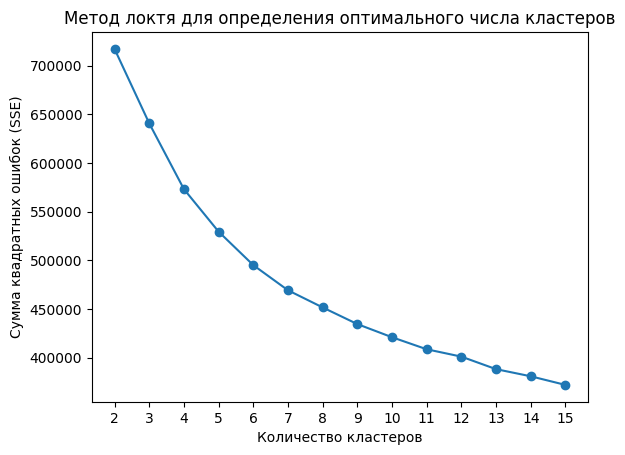

In [10]:
find_optimal_clusters(X[:2000000], max_k=15)

In [ ]:
km = KMeans(n_clusters=6, random_state=17)
km.fit(X[:2000000])

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
batch_size = 100000

# Контейнер для хранения меток кластеров
cluster_labels = []

# Итеративная инференция на больших данных
for start in range(0, len(df), batch_size):
    end = start + batch_size
    batch_texts = df['text'][start:end]

    # Преобразование текстов в числовое представление
    X_batch = vectorizer.transform(batch_texts)

    # Предсказание кластеров
    clusters = kmeans.predict(X_batch)

    # Добавление меток кластеров в итоговый список
    cluster_labels.extend(clusters)

## Файнтюн


In [6]:
df_test = pd.read_csv("/kaggle/input/avito-support/test_dataset.csv")
df_train_finetune = pd.read_csv("/kaggle/input/avito-support/finetune.csv")

reverse_emotions_labels = [0, 1, 5, 2]
df_train = df_train_finetune.copy()

label_mapping = {0: reverse_emotions_labels[0],
                 1: reverse_emotions_labels[1],
                 2: reverse_emotions_labels[2],
                 3: reverse_emotions_labels[3]}

df_train['label'] = df_train['label'].map(label_mapping)
df_test['label'] = df_test['label'].map(label_mapping)

In [7]:
LABELS = ['no_emotion', 'joy', 'sadness', 'surprise', 'fear', 'anger']

def binarize_labels(labels):
    return [i == labels for i in range(6)]

In [8]:
df_train['label'] = df_train['label'].apply(binarize_labels)
df_test['label'] = df_test['label'].apply(binarize_labels)

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_cedr_name)
model = AutoModelForSequenceClassification.from_pretrained(model_cedr_name)
model.to(DEVICE)

tokenizer_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

In [10]:
def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [11]:
def predict_with_model(model, dataloader):
    preds = []
    facts = []

    for batch in tqdm(dataloader):
        facts.append(batch['labels'].cpu().numpy())
        batch = {key: val.to(model.device) for key, val in batch.items()}
        with torch.no_grad():
            output = model(**batch)
        preds.append(torch.sigmoid(output.logits).cpu().numpy())
    facts = np.concatenate(facts)
    preds = np.concatenate(preds)
    return facts, preds

def get_classification_report(facts, preds):
    aucs = []
    for i in range(facts.shape[1]):
        if len(np.unique(facts[:, i])) == 1:
            auc = np.nan
        else:
            auc = roc_auc_score(facts[:, i], preds[:, i])
        aucs.append(auc)
    return aucs

def evaluate_model(model, dev_dataloader, verbose=False):
    facts, preds = predict_with_model(model, dev_dataloader)
    aucs = get_classification_report(facts, preds)
    if verbose:
        print('AUCs:', aucs)
        print('Mean AUC:', np.nanmean(aucs))
    return np.nanmean(aucs)

In [12]:
def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True)

In [13]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encodings = self.tokenizer(text, padding='max_length', truncation=True, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encodings.items()}
        item['labels'] = torch.tensor(label).float()
        return item

    def __len__(self):
        return len(self.labels)

In [14]:
train_dataset = EmotionDataset(
    texts=df_train['msg_text'].tolist(),
    labels=df_train['label'].tolist(),
    tokenizer=tokenizer
)

test_dataset = EmotionDataset(
    texts=df_test['msg_text'].tolist(),
    labels=df_test['label'].tolist(),
    tokenizer=tokenizer
)

In [22]:
gradient_accumulation_steps = 1
window = 500
cleanup_step = 100
report_step = 5000
ewm_loss = 0
batch_size = 16
lr = 1e-5
epochs = 1

In [16]:
data_collator = DataCollatorWithPadding(tokenizer)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
dev_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=data_collator)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [18]:
evaluate_model(model, dev_dataloader, verbose=True)

  0%|          | 0/108 [00:00<?, ?it/s]

AUCs: [0.7553575757575757, 0.9497098360655737, 0.45951475409836073, nan, nan, 0.5026786885245902]
Mean AUC: 0.6668152136115251


0.6668152136115251

In [ ]:
for epoch in trange(epochs, desc='Epochs'):
    tq = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}')
    
    for i, batch in enumerate(tq):
        try:
            batch = {key: val.to(model.device) for key, val in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
        except RuntimeError as e:
            print('Error on step', i, e)
            loss = None
            cleanup()
            continue

        if i and i % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            
        if i % cleanup_step == 0:
            cleanup()

        w = 1 / min(i+1, window)
        ewm_loss = ewm_loss * (1-w) + (loss.item() if loss is not None else 0) * w
        tq.set_postfix(loss=f'{ewm_loss:.4f}', refresh=False)
        
        if i % report_step == 0:
            model.eval()
            eval_loss = evaluate_model(model, dev_dataloader, verbose=True)
            model.train()
            tqdm.write(f'Epoch {epoch}, step {i}: train loss: {ewm_loss:.4f}  val auc: {eval_loss:.4f}')

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/20037 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1 [00:29<?, ?it/s]

AUCs: [0.20134242424242424, 0.9945049180327868, 0.9819090163934426, nan, nan, 0.9690721311475409]
Mean AUC: 0.7867071224540487
Epoch 0, step 0: train loss: 0.0024  val auc: 0.7867


  0%|          | 0/108 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1 [1:13:51<?, ?it/s]

AUCs: [0.16864242424242423, 0.993227868852459, 0.9835852459016394, nan, nan, 0.9736606557377049]
Mean AUC: 0.7797790486835569
Epoch 0, step 5000: train loss: 0.0131  val auc: 0.7798


In [20]:
model.save_pretrained("bert_2")
tokenizer.save_pretrained("tokenizer_2")

('tokenizer_1/tokenizer_config.json',
 'tokenizer_1/special_tokens_map.json',
 'tokenizer_1/vocab.txt',
 'tokenizer_1/added_tokens.json',
 'tokenizer_1/tokenizer.json')

In [ ]:
print(5)

In [ ]:
print(5)

In [ ]:
print(5)

In [ ]:
print(5)